# Pittsburgh Crime Analysis

## Project Scope
We are interested in what impacts crime in a neighbourhood. Crime, being inherently random, is difficult to model and predict. However, there a number of neighbourhoods in Pittsburgh that have be characterized as being "safe" - Squirrel Hill for example. There must be certain socioeconomic features in these neighbourhoods that attribute to lower crime rates, and we will attempt to use some of these features to create a model that can predict the number of crimes occuring in a neighbourhood.

1. [Initial Visualizations](#Initial-Visualizations) 
We will visualize daily,weekly and monthly crime rates to find any patterns in types of crime (thefts, rapes etc). Is crime higher on the Weekdays vs Weekends? Does temperature affect crime? Are there any patterns for holidays vs working days?

2. [Crime Prediction](#Crime-Prediction) 
We will attempt to predict the number of crimes that occur per neighbourhood and observe the fit. 

3. [Statistically Significant Features](#Statistically-Significant-Features) We would like to see if there are any socio-economic and demographic factors that contribute to the relatively lower crime rates of these neighbourhoods. Namely, we will create a (fairly large) subset of variables that we think should have a impact on crime (Median Home Value, % Employed in Neighbourhood, % High School Graduates...) and run hypothesis tests to see if these variables do indeed have some impact on crime in that neighbourhood. 


## Data

1. Pittsburgh police blotter dataset obtained from https://data.wprdc.org/dataset/pittsburgh-police-incident-blotter
The police blotter dataset is a listing of arrests in Pittsburgh documented shortly after an arrest is made. An arrest occurs but it does not include investigative, intelligence, nor treatment (medical) data. The information is "semi-refined" ie. a police report was taken, but it hadn't made its way through the court system nor the Uniform Crime Report. We will use this data for daily, weekly and trend visualizations. 

2. PGHSNAP Census 2010 Data obtained from http://www.pittsburghpa.gov/dcp/snap/raw_data
The Census data has demographic details of Pittsburgh. It breaks down the population by neighbourhoods and it gives the racial make up of each neighbourhood. It also gives the number of housing units in a neighbourhood and breaks it down by units occupied and vacant. This dataset is used for predictions, and is defined in detail in the later part of the report.


## Data Preprocessing

First, we import the libraries. We will be using urllib2 and BeautifulSoup to parse the HTML, and pandas for the csv processing.

In [90]:
import urllib2
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as st
import quandl
from collections import Counter
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, feature_selection, ensemble
import random
%matplotlib inline
matplotlib.use("svg")
plt.style.use("ggplot")
from PIL import Image
import glob

Each crime in our dataset belongs to a category, or type, of crime. This category is labeled by the SECTION column. To map this SECTION number to the description of the type of crime, we need to parse the Pittsburgh crime website for this information. We did this by retrieving the HTML using urllib2, and use BeautifulSoup and regex pattern matching to obtain the section, or chapter, names and descriptions

In [2]:
web_page = urllib2.urlopen("http://www.legis.state.pa.us/WU01/LI/LI/CT/htm/18/18.htm").read()
soup = BeautifulSoup(web_page, "lxml")

In [3]:
descriptions = {}
for chapter in soup.find_all(text=re.compile('Chapter .* \xa0')):
    chapter_split = chapter.split()
    num = int(chapter_split[1][:-1])
    desc = " ".join(chapter_split[2:])
    descriptions[num] = desc
    
print descriptions

{1: u'General Provisions', 3: u'Culpability', 5: u'General Principles of Justification', 7: u'Responsibility (Reserved)', 9: u'Inchoate Crimes', 11: u'Authorized Disposition of Offenders', 13: u'Authority of Court in Sentencing (Transferred)', 21: u'Offenses Against the Flag', 23: u'General Provisions', 25: u'Criminal Homicide', 26: u'Crimes Against Unborn Child', 27: u'Assault', 29: u'Kidnapping', 30: u'Human Trafficking', 31: u'Sexual Offenses', 32: u'Abortion', 33: u'Arson, Criminal Mischief and Other Property Destruction', 35: u'Burglary and Other Criminal Intrusion', 37: u'Robbery', 39: u'Theft and Related Offenses', 41: u'Forgery and Fraudulent Practices', 43: u'Offenses Against the Family', 45: u'General Provisions', 47: u'Bribery and Corrupt Influence', 49: u'Falsification and Intimidation', 51: u'Obstructing Governmental Operations', 53: u'Abuse of Office', 55: u'Riot, Disorderly Conduct and Related Offenses', 57: u'Wiretapping and Electronic Surveillance', 59: u'Public Indece

We will load the csv file into a dataframe so we can process it.

In [4]:
Crime = pd.read_csv("Pittsburgh Crime Dataset.csv")
print Crime.dtypes
print len(Crime)

_id               int64
REPORT_NAME      object
CCR               int64
SECTION          object
DESCRIPTION      object
ARREST_TIME      object
ADDRESS          object
NEIGHBORHOOD     object
ZONE            float64
AGE             float64
GENDER           object
dtype: object
117717


We then need to filter out all of the rows with bad section data, that have sections that don't correspond to crime categories properly.

In [5]:
# Get only rows that have sections with numeric sections corresponding to the type of crime.
cleaned = Crime[Crime.apply(lambda x: x['SECTION'].isdigit() and len(x['SECTION'])>=3, axis=1)]
print len(cleaned)

81574


We remove the last 2 digits of the section to retrieve the broader section number, and create columns for this broad section number and crime description, saving this to a new csv.

In [6]:
cleaned['CrimeNum'] = cleaned['SECTION'].apply(lambda x: int(x[:-2]))
cleaned = cleaned[cleaned.apply(lambda x: x['CrimeNum'] in descriptions, axis=1)]
cleaned['CrimeDescription'] = cleaned['CrimeNum'].apply(lambda x: descriptions[x])
print len(cleaned)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


72753


We can run interesting analysis now that we have the crimes categorized. For example, we can see the most common crimes that happened in Pittsburgh, the most common being Assault.

In [7]:
s=0
d={}
for (ind,sec) in cleaned.groupby('CrimeNum'):
    d[descriptions[ind]] = len(sec)
    s+=len(sec)
top5crimes = Counter(d).most_common(5)
print top5crimes

# Crime Victims are "crimes" involving a self-inflicted injury, mental illness, false alarm, etc.

[(u'Assault', 12660), (u'Theft and Related Offenses', 11248), (u'Robbery', 9778), (u'Arson, Criminal Mischief and Other Property Destruction', 7519), (u'Crime Victims', 5518)]


# Initial Visualizations
Let's inspect our data better by visualizing it. We have done a couple of visualizations in Tableau and will import the images here.

In [71]:
image_list = []
for filename in glob.glob('Tableau Charts\*.png'):
    im=Image.open(filename)
    image_list.append(im)

Lets look at how crimes vary per month. The below plot shows us that is seasonality - crimes appear to spike up when its Summer and reduce during Winter. Temperature can play a role into the amount of crimes.

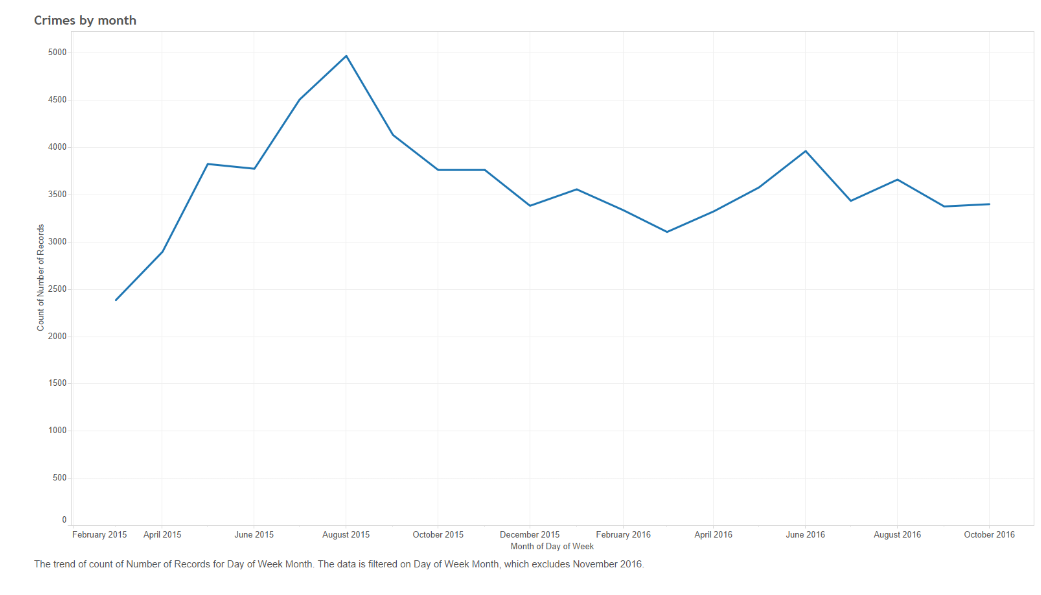

In [77]:
plt.figure(figsize = (30,10))
plt.axis('off')
plt.imshow(np.asarray(image_list[1]));

Disorderly Conduct is related to alcohol consumption and hence spikes over the weekends.
Thefts are generally lower in the weekends as there are people who are at home, and hence burglaries are robberies are reduced as thieves would prefer an empty house. Using intuition it's difficult to figure out why "Obstructing Governmental Operations" spikes over the weekend - we will need more data to find if there is any correlation.

We need to group by date,time and hour to get further visualizations using matplotlib -

In [79]:
pittdf = cleaned

array(['_id', 'REPORT_NAME', 'CCR', 'SECTION', 'DESCRIPTION',
       'ARREST_TIME', 'ADDRESS', 'NEIGHBORHOOD', 'ZONE', 'AGE', 'GENDER',
       'CrimeNum', 'CrimeDescription', 'Date', 'Time'], dtype=object)

In [158]:
pittdf[['ARREST_TIME']] = pittdf[['ARREST_TIME']].apply(pd.to_datetime) ##Datetime
pittdf['Date'] = pittdf['ARREST_TIME'].dt.date #Convert to date
pittdf['Time'] = pittdf['ARREST_TIME'].dt.time 
pittdf[['Date']] = pittdf[['Date']].apply(pd.to_datetime)

pittdf = pittdf.drop_duplicates(['CCR']) #Certain crimes can have duplicated records (more than 1 person arrested). Remove duplicates
pittdf = pittdf.reset_index(drop=True)

In [81]:
# Extracting hour,week number and day
pittdf['Hour']=[pittdf['ARREST_TIME'][i].hour for i in range(len(pittdf))]
pittdf['weekno'] = [pittdf['ARREST_TIME'][i].isocalendar()[1] for i in range(len(pittdf))]
pittdf['day']=[pittdf['ARREST_TIME'][i].weekday() for i in range(len(pittdf))]

#Grouping
groups = pittdf.groupby('Date').agg('count')
groupsWeekday = pittdf.groupby('day').agg('count')
groupsWeek = pittdf.groupby('weekno').agg('count')
groupsTime = pittdf.groupby('ARREST_TIME').agg('count')
groupsHour = pittdf.groupby('Hour').agg('count')
groups1 = groups[['CCR']]

We now look at how hour of day varies with the number of crimes. Looking at the graph, we can notice an unusual spike in crimes from 3PM-6PM

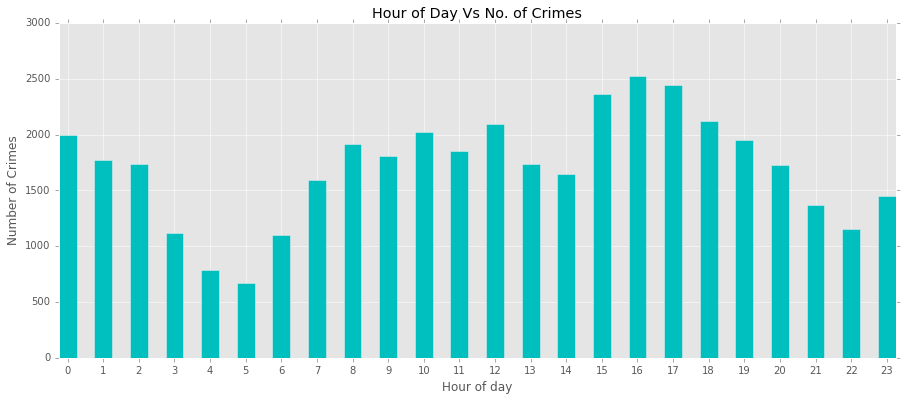

In [93]:
plt.figure(figsize = (15,6))
plt.title("Hour of Day Vs No. of Crimes")
plt.xlabel("Hour of day")
plt.ylabel("Number of Crimes")
plt.xticks(groupsHour.index)
plt.bar(groupsHour.index, groupsHour.CCR,width=0.5,color='c',align='center');

Below is a plot for total crimes, for each day
of the week. In general, there does not seem to be much difference for each day and the total number of crimes..

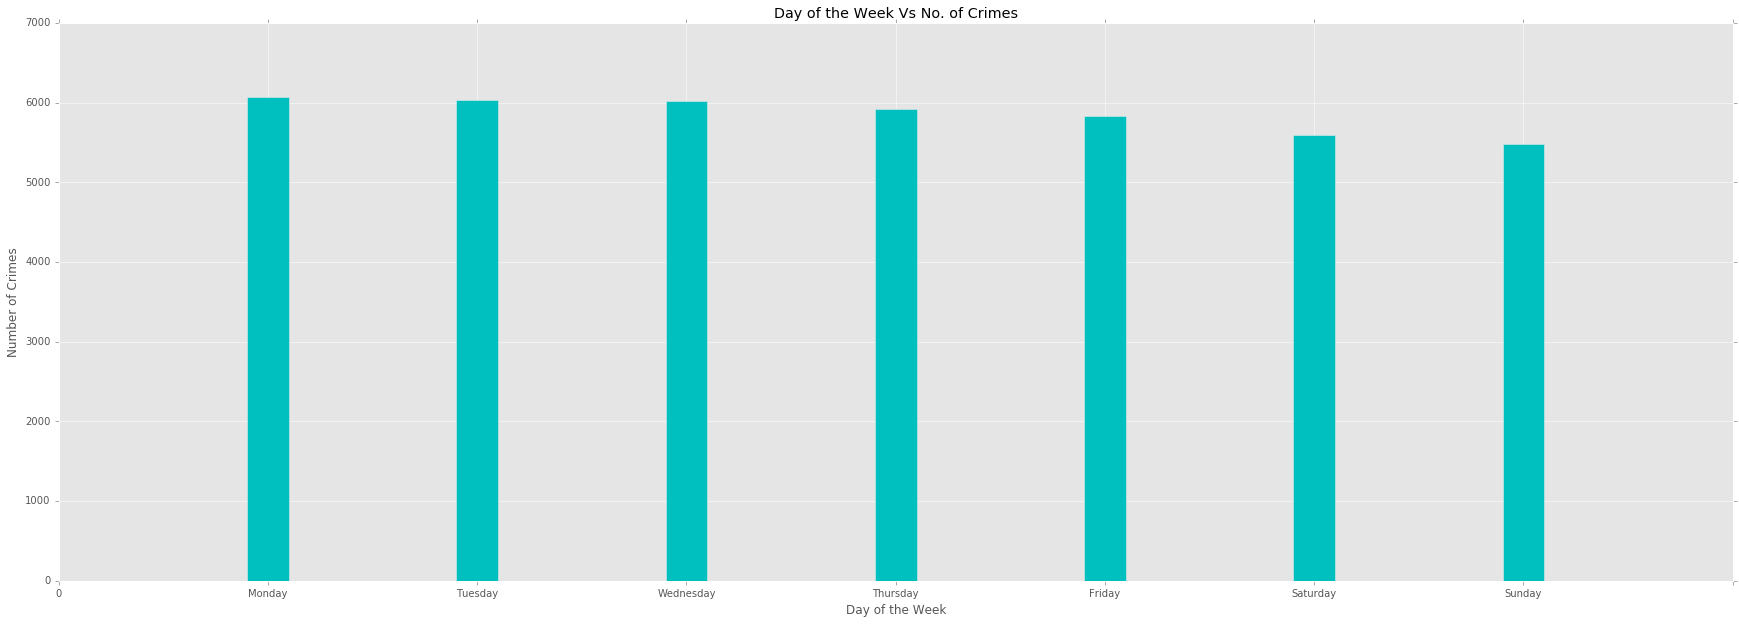

In [103]:
fig, ax = plt.subplots(figsize = (30,10))
fig.canvas.draw()
labels = ['0','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax.set_xticklabels(labels)
plt.title("Day of the Week Vs No. of Crimes")
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.bar(groupsWeekday.index, groupsWeekday.CCR,width=0.2,color='c',align='center');

We notice that there is a downward trend in total crimes Monday through Sunday.

We then checked individual crimes by Day of the week to see if there was any correlation. Three crimes stood out as having a clear difference - Obstructing Governmental Operations, Disorderly Conduct and Theft. The plots are below -

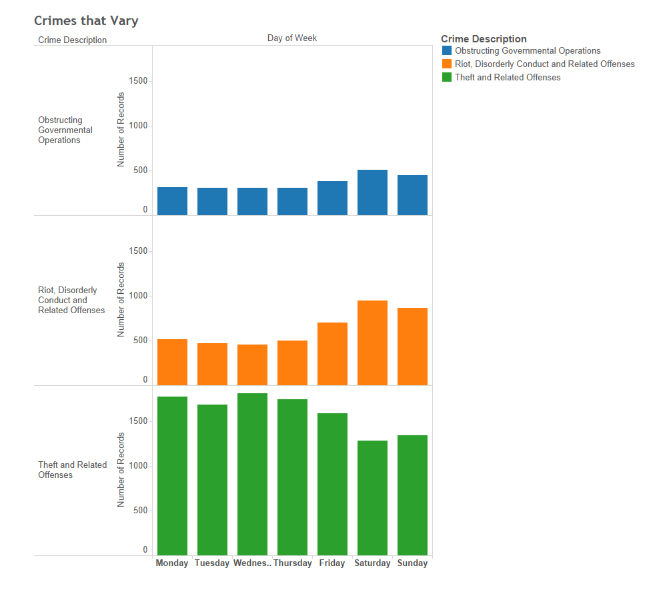

In [75]:
plt.figure(figsize = (30,10))
plt.axis('off')
plt.imshow(np.asarray(image_list[2]));

We plot the total crimes per hour above and notice that there is an unusual spike in the number of crimes from 3:00 PM till 6:00 PM.

## Checking Stationarity

In the following block of code we test the stationarity of the data using the dickey-fuller test. We also plot the graph of the time series data with the rolling mean and the rolling standard deviation. 

In [56]:
def stationarity_test(timeseries,values):
    
    #Determing the rolling statistics for a month for the data 
    rollingmean = timeseries.rolling(window=30,center=True).mean()
    rollingstd = timeseries.rolling(window=30,center=True).std()
    
    #Plotting the rolling statistics
    orig = plt.plot(timeseries, color='c',label='Original')
    mean = plt.plot(rollingmean, color='red', label='Rolling Mean')
    std = plt.plot(rollingstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for the Time Series')
    plt.show(block=True)
    
    #Performing the Dickey-Fuller test:
    print 'Results of the Dickey-Fuller Test:'
    pittdftest = adfuller(values, autolag='AIC')
    pittdfoutput = pd.Series(pittdftest[0:4], index=['Test Statistics','P-value','No. of Lags Used','Number of Observations Used'])
    for key,value in pittdftest[4].items():
        pittdfoutput['Critical Value (%s)'%key] = value
    print pittdfoutput
    

# The Dickey Fuller test code has been referenced from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

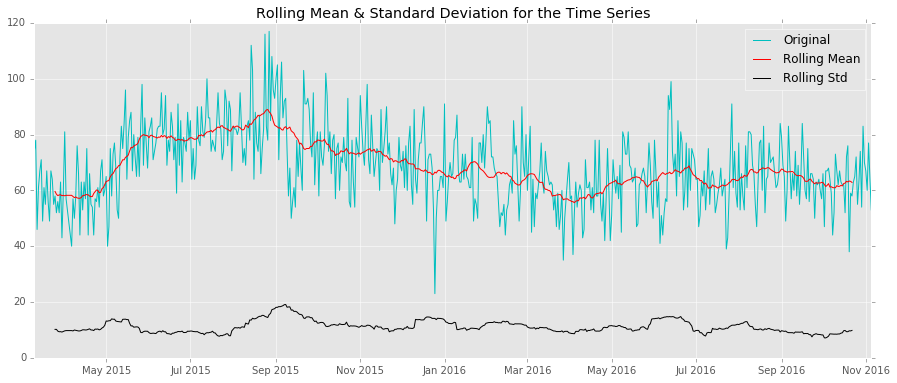

Results of the Dickey-Fuller Test:
Test Statistics                 -4.594797
P-value                          0.000132
No. of Lags Used                 6.000000
Number of Observations Used    591.000000
Critical Value (5%)             -2.866443
Critical Value (1%)             -3.441463
Critical Value (10%)            -2.569381
dtype: float64


In [57]:
stationarity_test(groups1,groups1.CCR)


The p-value is 0.1899 which proves that there is trend and seasonality in the data and is not as stationary. 

# Socio-Economic Data - PGHSNAP Dataset
We have, by neighbourhood, various other factors for the year 2010. We can use these to better understand what variables are statistically significant for each type of crime, and also to attempt to predict crime rates per neighbourhood. The dataset contains aggregated census + crime data at the neighbourhood for the year 2010.

1. Racial Make-Up (% White, % African American , % Asian and so on)
2. Population Data from 1940-2010
3. Land Data (Persons / Acre , Total Land Area, Park Space, Greenway Space..)
4. Age Groups ( % Pop Age <5 , % Pop Age 5-20..)
5. Home Information (% Owner Occupied, Median Home Price, % Change in Price Mean Years of Residence..)
6. Employment Data ( % Employed, Resident Jobs : Construction , Resident Jobs : Finance..)
7. Education Data (% High School Graduates, % Masters..)
8. Crime Data (# Murder, # Rape, # Burglary...)  

We selected a subset of data that we thought would be useful for the prediction of crime in an area. Variables like Sector Number, % Commute to work via freeway etc., population data from 1940-1950 were ignored as we did not think they would be useful in predicting the number of crimes in 2010. We will use this aggregated crime data to train our model and see how well they do at prediction.

In [153]:
all_data = pd.read_csv('Dataset_PGHSNAP_Useful.csv', na_values=['N/A','n/a'])
dupcols=[]
for i in range(10):
    dupcols += list(all_data.columns[all_data.columns.map(lambda x: x[-2:] == ".%s" % i)])
df = all_data.drop(dupcols, axis=1)
all_data.columns.values

array(['Neighborhood', '% African American (2010)', '% Asian (2010)',
       '% Other (2010)', '% White (2010)', '% 2+ Races (2010)',
       '% Hispanic (of any race) (2010)', 'Persons / acre (2010)',
       'Pop. 2010', 'Pop. as % of City total (2010)',
       '% Pop. Age 5-19 (2010)', '% Pop. Age 20-34 (2010)',
       '% Pop. Age 35-59 (2010)', '% Pop. Age 60-74 (2010)',
       '% Pop. Age > 75 (2010)', 'Total # Units (2010)',
       '% Vacant Units (2010)', '% Owner Occupied Units (2010)',
       'Est. Avg. Yrs. of Residence (2010)', 'Median Home  Value (2010)',
       '% Change Real Value 2000-2010', 'Ratio Employed',
       'Resident Jobs: Construction', 'Resident Jobs: Manufacturing',
       'Resident Jobs: Retail Trade',
       'Resident Jobs: Transportation, warehousing, utilities',
       'Resident Jobs: Information',
       'Resident Jobs: Finance, insurance, real estate',
       'Resident Jobs: Prof, scientific, admin, and waste mgmt',
       'Resident Jobs: Educ, health and

We will now combine related features together so as to create more informative features. This is also required to remove interdependence amongst variables. 

In [65]:
# Combining features 
df["Theft"] = df["#Robbery (2010)"] + df["#Burglary (2010)"] + df["#Auto Theft (2010)"]
df["White Collar Jobs"] = df['Resident Jobs: Information'] + df['Resident Jobs: Prof, scientific, admin, and waste mgmt'] + df['Resident Jobs: Finance, insurance, real estate'] + df['Resident Jobs: Public admin']
df["Highly Educated"] = df['Edu. Attainment: Assoc./Prof. Degree (2010)'] + df["Edu. Attainment: Bachelor's Degree (2010)"] + df['Edu. Attainment: Postgraduate Degree (2010)']
df["% Above 35"] = df['% Pop. Age 35-59 (2010)'] + df['% Pop. Age 60-74 (2010)'] + df['% Pop. Age > 75 (2010)']

#Removing extra features
df.drop(["% Vacant Units (2010)","% of all Bldgs. Condemned (2010)","#Robbery (2010)","#Burglary (2010)","#Auto Theft (2010)",'Resident Jobs: Information','Resident Jobs: Prof, scientific, admin, and waste mgmt','Resident Jobs: Prof, scientific, admin, and waste mgmt','Resident Jobs: Finance, insurance, real estate','Resident Jobs: Public admin', 'Resident Jobs: Construction', 'Resident Jobs: Manufacturing',
       'Resident Jobs: Retail Trade',
       'Resident Jobs: Transportation, warehousing, utilities',
       'Resident Jobs: Educ, health and social svc',
       'Resident Jobs: Arts, ent, recreation, accommodation and food services',
       'Edu. Attainment: Less than High School (2010)',
       'Edu. Attainment: High School Graduate (2010)',
       'Edu. Attainment: Assoc./Prof. Degree (2010)',
       "Edu. Attainment: Bachelor's Degree (2010)",
       'Edu. Attainment: Postgraduate Degree (2010)',
        '% Pop. Age 35-59 (2010)',
        '% Pop. Age 60-74 (2010)', '% Pop. Age > 75 (2010)'],axis = 1, inplace = True) 

crimes = ['Part 1 Crime per 100 Persons (2010)', 'Part 2 Crime per 100 Persons (2010)']
all_data_values = df.drop(['Neighborhood','#Rape (2010)','#Murder (2010)']+crimes, axis=1).dropna()

## Crime Prediction
Our next goal was to predict the yearly crime rates for a neighborhood given several characteristics about that neighborhood, taken from the census data. In addition to predicting overall crime rate, we looked into predicting the rates of specific types of crimes: Theft, Assault, and Drug Violations.

Data - https://www.census.gov/geo/maps-data/data/tiger-data.html

In [151]:
# Returns fitted Gradient Boosting Regression model for the training data
def reg_gbr(X_train,Y_train):
    regr = ensemble.GradientBoostingRegressor()
    regr.fit(X_train, Y_train)
    return regr

# Given X and Y data corresponding to a type of crime, divide the data into training
# and test sets 85%/15% split, train the regression model, and predict the test data.
# Then, plot the accuracy (sorted for easier analysis) with the r^2 value
def run_regression(X,Y, plot_num, plot_name):
    scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
    X_scaled = scaler.fit_transform(X)
    Y_scaled = np.array(Y)

    numTrain = int(len(X_scaled) *.85)

    X_train = X_scaled[:numTrain]
    Y_train = Y_scaled[:numTrain]
    X_test, Y_test = zip(*sorted(zip(X_scaled[numTrain:],Y_scaled[numTrain:]), key=lambda x:x[1]))

    model_gbr = reg_gbr(X_train, Y_train)
    model_gbr_y = model_gbr.predict(X_test)
    
    r2 = metrics.r2_score(Y_test, model_gbr_y)
    
    plt.subplot(2,2,plot_num)
    plt.plot(Y_test)
    plt.plot(model_gbr_y)
    plt.axis('off')
    plt.title(plot_name + ": (r^2 value: %.2f)" % r2)
    plt.legend(['truth', 'prediction'], loc='upper left', prop={'size':7})

To do the prediction, we experimented with many types of models. We looked at different classification models, dividing our neighborhoods into bins of low, medium, and high crime rates. This did not get as good results, so we tried different regression models. We ultimately found that the ensemble method, Gradient Boosting Regression, performed the best. The nonlinearity in our data meant that linear regression would not be a viable fit. Boosted regression via decision trees performs better due to its ability to make use of multiple weak decision trees with high variance and low bias to solve the bias-variance tradeoff, giving a better predictive model.

So, for each type of crime (Theft, Assault, and Drug Violations) and for overall crime, we predicted the crime rates for the test neighborhoods given the selected census data as features.

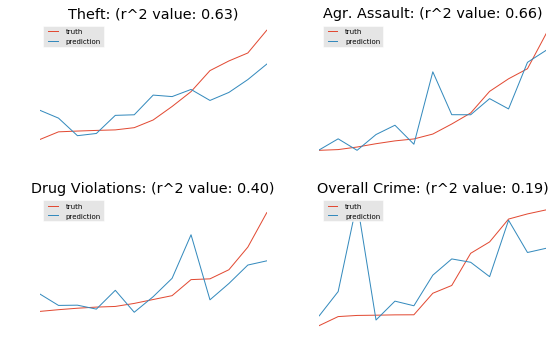

In [157]:
all_data_values = all_data_values.reindex(np.random.permutation(all_data_values.index))
X = all_data_values.drop(['Theft','Crime Per 100 Persons','#Agr. Assault (2010)','#Drug Violations (2010)'], axis=1)

plt.figure(figsize=(8,5))

Y = all_data_values['Theft'] / all_data_values['Pop. 2010'] * 100
run_regression(X,Y,1, 'Theft')

Y = all_data_values['#Agr. Assault (2010)'] / all_data_values['Pop. 2010'] * 100
run_regression(X,Y,2, 'Agr. Assault')

Y = all_data_values['#Drug Violations (2010)'] / all_data_values['Pop. 2010'] * 100
run_regression(X,Y,3, 'Drug Violations')

Y = all_data_values['Crime Per 100 Persons']
run_regression(X,Y,4, 'Overall Crime')

plt.tight_layout()

The above graph shows us how predicting crime at an individual level allows our model to perform better than attempting to predict crime at an aggregate level. There are certain variables that are statistically significant for each type of crime, and attemping to predict at an aggregated level can lead to mixed results. 

For our model, the statistically significant variables are plotted and shown below.

## Statistically Significant Features
Using hypothesis testing for linear regression, we determined which features have a statistically significant impact on the crime rate. Also, we looked at how these features varied over different kinds of crime (Theft, Assault, and Drug Violations).

In [117]:
def get_best_features(X,Y):
    F,p = feature_selection.f_regression(X,Y)
    p_values = zip(X.columns.values,p)

    one_hot = [False]*len(X.columns)
    for i,j in sorted(p_values, key = lambda p:p[1]):
        if j <0.1:
            one_hot[X.columns.get_loc(i)]=True
            
    return one_hot

In [118]:
Y = all_data_values['Theft'] / all_data_values['Pop. 2010'] * 100
theft_1hc = get_best_features(X,Y)

Y = all_data_values['#Agr. Assault (2010)'] / all_data_values['Pop. 2010'] * 100
aa_1hc = get_best_features(X,Y)

Y = all_data_values['#Drug Violations (2010)'] / all_data_values['Pop. 2010'] * 100
drug_1hc = get_best_features(X,Y)

Y = all_data_values['Crime Per 100 Persons']
overall_1hc = get_best_features(X,Y)

onehc_table = np.array([theft_1hc, aa_1hc, drug_1hc, overall_1hc])

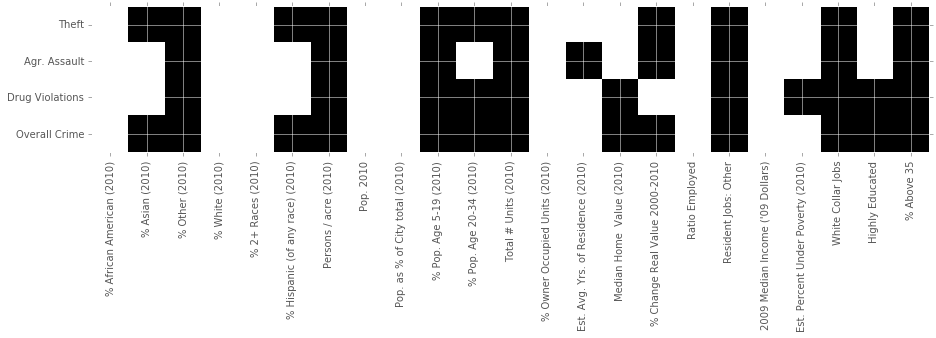

In [121]:
plt.figure(figsize=(15,10))
plt.imshow(onehc_table,cmap=plt.cm.gray, interpolation='nearest')
ylabels = list(X.columns)
xlabels = ['Theft','Agr. Assault','Drug Violations','Overall Crime']

plt.xticks(range(len(ylabels)), ylabels, rotation=90)
plt.yticks(range(4), xlabels, rotation=0);

The above diagram shows the statistically significant features in white, and those not significant in black.
Features that are significant across all types of crimes are:
- Race
- Population
- Percentage of interracial housholds
- Percent of owner occupied units
- Years of residence
- Employment
- Median income
- Percentage under poverty.

These features mostly make sense. Neighborhoods that are more poor might have more people being desperate and committing theft, or uncaring of the consequences and committing other crimes. The relation with race may be because of its relation with socioeconomic status.


Features that are not significant across all types of crimes are:
- Density of population
- Percentage of population that are under 20
- Type of job distribution
- Percentage of population that are over 35


These features not being significant also mostly make sense. Though some correlations may be drawn between the density of the population and median income, and therefore crime rates, our data may have too much variance for these features to make an impact.

We also found how certain features were significant to specific types of crimes.

Features that were significant to specific types of crimes.
- Percentage of population between 20 and 35 was only significant to assaults
- Years of residence were only not significant to assaults
- Change in housing prices were only significant to drug violations
- Median home value was only not significant to drug violations
- Percent under poverty were only not significant to drug violations
- Percent highly educated were only not significant to drug violations

These observations likely come mostly from the variance and bias in our data. However, some of these correlations make sense. For example, perhaps drug violations are common across those in and out of poverty. Also, perhaps one's education does not decrease the likelyhood that one commit and be caught for a drug violation.

More research with more data needs to be done to confirm these hypotheses.

# Other Relevant Work
We found a paper that uses "classical" statistics to describe how to predict crime in Pittsburgh for different neighbourhood. This paper models the rate of crimes using Gaussian Processes and a Poisson Distribution. While we are doing aggregate yearly predictions on crime data, there lies scope into seeing how these two approaches can be combined to create a model that can better predict total crimes.

https://www.ml.cmu.edu/research/dap-papers/dap_flaxman.pdf

There is also research on the correlation of seismology models and the occurrences of crime. Earthquakes occur at fixed rates and along existing fault lines. Crime follows a similar phenomenon where crimes are caused by features of the environment like smaller criminal successes in a neighborhood which leads to more crimes. 

http://www.sciencemag.org/news/2016/09/can-predictive-policing-prevent-crime-it-happens

# Future Possibilities

In this project, we have looked into aggregate level predictions per Neighbourhood, attempted to create a model that can model these crimes, and looked at which variables are most statistically significant to crime rates.

However, crime being inherently random, is very difficult to predict on a daily level. To expand this project, we would like to conduct the same experiment with more data. To increase the number of training examples, we could use smaller sections, such as census tracts, instead of full neighborhoods. Since the Census and PGHSnap would not have that information, we would have to get that information from a seperate dataset, and the Pittsburgh crime dataset was too small for tract level analysis. However, we would like to use the [Chicago Crime Dataset](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data) combined with the census information to make more accurate predictions.

Also, one can further perform geospatial analysis on the locations of the crimes within Pittsburgh and Chicago, to see where crime happens most in each neighborhood.